#Combined(GEN & SR) For 128x128

## Prerequisite

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install tensorflow==1.15
!pip install tensorflow-gpu==1.15
!pip install keras==2.2.3

     |████████████████████████████████| 412.3MB 31kB/s 
     |████████████████████████████████| 3.8MB 36.8MB/s 
     |████████████████████████████████| 512kB 36.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=8c9998ab63a53f331270e766a5670c17e25b3a5182e77538fe0a664fc85b3b4f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: 

## Necessary Imports 

In [5]:
import numpy as np # linear algebra

import os
import sys
from tqdm import tqdm, tqdm_notebook
import glob
import shutil
import time      # time.perf_counter()
import random

import matplotlib.pyplot as plt
import cv2

import xml.etree.ElementTree as ET

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import image

Using TensorFlow backend.


## Constants

In [0]:
# image size
img_size = 128
channels = 3
img_shape = (img_size, img_size, channels)    # (128,128,3)

# z(latent variable) size
z_dim = 100
z_shape = (z_dim,)

# gradient penalty coefficient "λ"
penaltyLambda = 10    # d_loss = f_loss - r_loss + λ･penalty

# critic(discriminator) iterations per generator iteration
trainRatio = 5

batch_size = 64        # 16 or 64 better?
rec_interval = 1000

DIR = os.getcwd()
DIRimg = "/content/drive/My Drive/Testing/"    #path for input directory 
DIRout ="/content/drive/My Drive/Generated"    #path for input directory 

## Image Loading and Resizing Function

In [0]:
def loadImage(fPath, resize = True):
    img = cv2.imread(fPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # BGR to RGB
    if resize:
        interpolation = cv2.INTER_CUBIC         # expantion
        img = cv2.resize(img, (img_size, img_size), interpolation = interpolation)  # resize
    return img

## Sample Images before Resizing

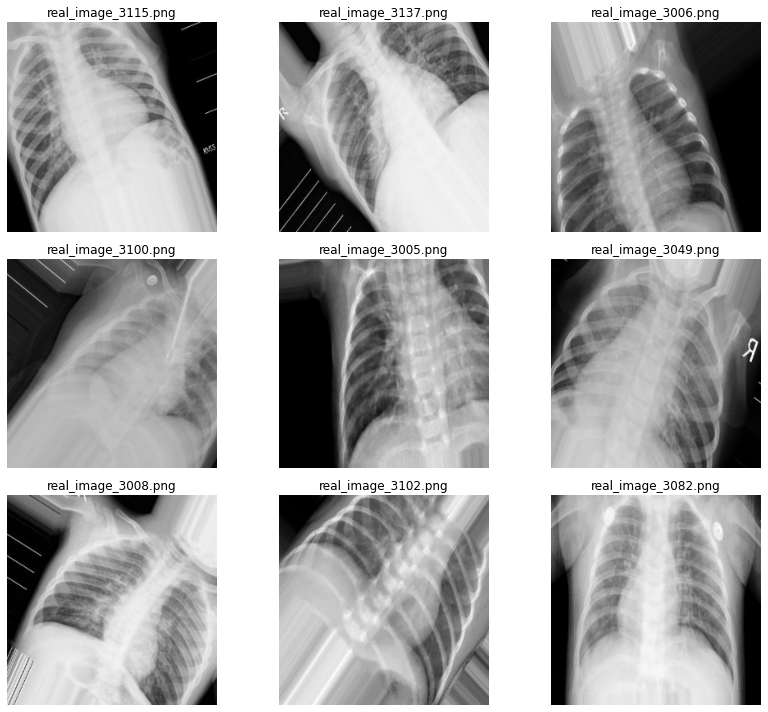

In [8]:
all_fNames = os.listdir(DIRimg)
# image sample
sample_ids = random.sample(range(len(all_fNames)), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
for i, axis in enumerate(axes.flatten()):
    img = loadImage(os.path.join(DIRimg,
                    all_fNames[sample_ids[i]]), resize=False)
    imgplot = axis.imshow(img)
    axis.set_title(all_fNames[sample_ids[i]])
    axis.set_axis_off()
plt.tight_layout()

## Samples Images after Resizing

## Convert Images to Train Data

In [9]:
# train data
x_train = np.zeros((len(all_fNames),img_size,img_size,3))
for i in tqdm(range(len(all_fNames))):
    path = os.path.join(DIRimg, all_fNames[i])
    x_train[i] = loadImage(path)

x_train = x_train / 255.
print(x_train.shape)

100%|██████████| 145/145 [00:41<00:00,  3.50it/s]

(145, 128, 128, 3)


## WGAN-gp Model

### Generator

In [0]:
def build_generator():
    input = Input(shape=z_shape)
    
    #8x8x1024
    x = Dense(4*img_size*img_size, activation="relu")(input)                            
    x = Reshape((8, 8, -1))(x)
    
    #8x8x1024 -> 16x16x512
    x = UpSampling2D((2, 2))(x)                                                         
    x = Conv2D(64*16, kernel_size=3, strides=1, padding="same", use_bias=False)(x)      
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*16, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*16, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    
    #16x16x512 -> 32x32x256
    x = UpSampling2D((2, 2))(x)                                                         
    x = Conv2D(64*8, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*8, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*8, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    
    #32x32x256 -> 64x64x128
    x = UpSampling2D((2, 2))(x)                                                         
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x,training=1)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    
    #64x64x128 -> 128x128x64
    x = UpSampling2D((2, 2))(x)                                                         
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x,training=1)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    
    #128x128x64 -> 128x128x3
    x = Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh", use_bias=False,)(x) 

    model = Model(input, x)
    print("●generator")
    model.summary()
    return model

### Discriminator

In [0]:
def build_discriminator():
    input = Input(shape=img_shape)
    
    # 128*128*3 -> 64x64x64 
    x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(input)
    x = LeakyReLU(0.2)(x)
    # 64x64x64-> 32x32x128 
    x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    # 32x32x128 -> 16x16x256  
    x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = Conv2D(512, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    # 16x16x256 -> 16x16x512
    x = Conv2D(512, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    # 16x16x512 -> 8x8x1024
    x = Conv2D(1024, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(1, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = Flatten()(x)
    x = Dense(units=1, activation=None)(x)   # activation = None
    
    model = Model(input, x)
    print("●discriminator")
    model.summary()
    return model

### WGan-gp Function

In [0]:
def build_WGANgp(generator, discriminator):
    #### model
    # generator image(fake image)
    z = Input(shape=z_shape)
    f_img = generator(z)
    f_out = discriminator(f_img)
    # real image
    r_img = Input(shape=img_shape)
    r_out = discriminator(r_img)
    # average image
    epsilon = K.placeholder(shape=(None,1,1,1))
    a_img = Input(shape=(img_shape),
                  tensor = epsilon * r_img + (1-epsilon) * f_img)
    a_out = discriminator(a_img)

    #### loss
    # original critic(discriminator) loss
    r_loss = K.mean(r_out)
    f_loss = K.mean(f_out)
    # gradient penalty  <this is point of WGAN-gp>
    grad_mixed = K.gradients(a_out, [a_img])[0]
    norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
    grad_penalty = K.mean(K.square(norm_grad_mixed -1))
    penalty = penaltyLambda * grad_penalty
    # d loss
    d_loss = f_loss - r_loss + penalty
    
    #### discriminator update function
    d_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
                get_updates(discriminator.trainable_weights,[],d_loss)
    d_train = K.function([r_img, z, epsilon],
                         [r_loss, f_loss, penalty, d_loss],
                         d_updates)
    
    #### generator update function
    g_loss = -1. * f_loss
    g_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
                get_updates(generator.trainable_weights,[],g_loss)
    g_train = K.function([z], [g_loss], g_updates)

    return g_train, d_train

## Build Training Model

In [13]:
# generator Model
generator = build_generator()
# discriminator Model
discriminator = build_discriminator()
# WGAN-gp Training Model
G_train, D_train = build_WGANgp(generator, discriminator)












●generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 1024)      9437184   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 1024)     

## Prepare Training

In [0]:
# fixed z for confirmation of generated image
z_fix = np.random.normal(0, 1, (64, z_dim)) 

# list for store learning progress data
g_loss_list = []
r_loss_list = []
f_loss_list = []
f_r_loss_list = []
penalty_list = []
d_loss_list = []

# (0～1) → (-1～+1)
X_train = (x_train.astype(np.float32) - 0.5) / 0.5

### Function for ploting Images

In [0]:
def sumple_images(imgs, rows=3, cols=3, figsize=(12,10)):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for indx, axis in enumerate(axes.flatten()):
        img = image.array_to_img(imgs[indx])    # ndarray → PIL
        imgplot = axis.imshow(img)
        axis.set_axis_off()
    plt.tight_layout()

## Perform Training

iteration:0 / d_loss:-25.278 / g_loss:62.283
Time Taken : 58.409165


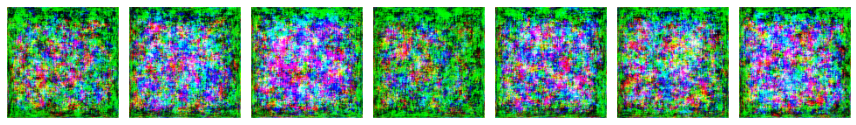

Done Iteration 1
iteration:1 / d_loss:-25.278 / g_loss:62.283
Time Taken : 59.727926
Done Iteration 2
iteration:2 / d_loss:-84.800 / g_loss:59.807
Time Taken : 22.190426
Done Iteration 3
iteration:3 / d_loss:-72.772 / g_loss:161.693
Time Taken : 22.365399
Done Iteration 4
iteration:4 / d_loss:-69.326 / g_loss:146.104
Time Taken : 22.492375
Done Iteration 5
iteration:5 / d_loss:-100.254 / g_loss:199.942
Time Taken : 22.455855
Done Iteration 6
iteration:6 / d_loss:-130.638 / g_loss:245.317
Time Taken : 22.469875
Done Iteration 7
iteration:7 / d_loss:-103.211 / g_loss:179.533
Time Taken : 22.472457
Done Iteration 8
iteration:8 / d_loss:-101.370 / g_loss:245.767
Time Taken : 22.436170
Done Iteration 9
iteration:9 / d_loss:-110.921 / g_loss:279.150
Time Taken : 22.416827
Done Iteration 10
iteration:10 / d_loss:-117.342 / g_loss:222.913
Time Taken : 22.391380


KeyboardInterrupt: ignored

In [16]:
import time

iteration = 0
while iteration<=2001:
    
    start_time = time.time()
    #### Discriminator
    for j in range(trainRatio):
        # Generator in
        z = np.random.normal(0, 1, (batch_size, z_dim))
        # Generator out Images
        f_imgs = generator.predict(z)
        # Real Images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        r_imgs = X_train[idx]
        # train the discriminator
        epsilon = np.random.uniform(size = (batch_size, 1,1,1))
        r_loss, f_loss, penalty, d_loss = D_train([r_imgs, z, epsilon])

    #### Generator
    # Generator in
    z = np.random.normal(0, 1, (batch_size, z_dim))
    # train the generator
    g_loss = G_train([z])

    #### Record of learning progress
    # loss
    r_loss_list.append(r_loss)
    f_loss_list.append(f_loss)
    f_r_loss_list.append(f_loss - r_loss)
    penalty_list.append(penalty)
    d_loss_list.append(d_loss)
    # generated image sumple
    if (iteration in [100, 1000]) or (iteration % 500 == 0):
        print(f'iteration:{iteration} / d_loss:{d_loss:.3f} / g_loss:{sum(g_loss)/len(g_loss):.3f}')
        print('Time Taken : %f' % (time.time()-start_time))
        g_imgs = generator.predict(z_fix)
        imgs = g_imgs * 127.5 + 127.5
        sumple_images(imgs, rows=1, cols=7)
        plt.show()

    iteration += 1
    print('Done Iteration %d'%iteration)
    print(f'iteration:{iteration} / d_loss:{d_loss:.3f} / g_loss:{sum(g_loss)/len(g_loss):.3f}')
    print('Time Taken : %f' % (time.time()-start_time))
print("last iteration:",iteration - 1)

## Plot the Graphs

In [0]:
# plot loss
fig, ax = plt.subplots(5, 2, figsize=(8.27,11.69))
for j in range(2):
    ax[0,j].plot(r_loss_list, label="r_los")
    ax[1,j].plot(f_loss_list, label="f_loss")
    ax[2,j].plot(f_r_loss_list, label="f-r_loss")
    ax[3,j].plot(penalty_list, label="penalty")
    ax[4,j].plot(d_loss_list, label="d_loss")
for i in range(5):
    ax[i,0].set_xlim([0,200])
    ax[i,1].set_xlim([200,iteration])
    for j in range(2):
        ax[i,j].grid()
        ax[i,j].legend()
plt.savefig('normal_128')
plt.show()

## Create Output Directory

In [0]:
if os.path.exists(DIRout):
    shutil.rmtree(DIRout)
if not os.path.exists(DIRout):
    os.mkdir(DIRout)

## Generate Sample Images Using Training Model

In [0]:
# generate images for submit
n = 5000
batch = 64
for i in tqdm(range(0, n, batch)):
    z = np.random.normal(0,1,size=(batch, z_dim))
    g_imgs = generator.predict(z)
    imgs = g_imgs * 127.5 + 127.5
    for j in range(batch):
        img = image.array_to_img(imgs[j])      # ndarray → PIL 
        img.save(os.path.join(DIRout, 'generated_' + str(i+j+1).zfill(5) + '.png'))
        if i+j+1 == n:
            break
print(len(os.listdir(DIRout)))

## Plot the sample Images

In [0]:
# generated xrays sumple
sumple_images(g_imgs, rows=5, cols=7, figsize=(12,8))

## Submit the Directory

In [0]:
if os.path.exists('xray_normal_128.zip'):
    os.remove('xray_normal_128.zip')
shutil.make_archive('xray_normal_128', 'zip', DIRout)
print("<END>")

# Super Resolution

## Extracting Files

In [18]:
cd /content/

/content


In [19]:

from zipfile import ZipFile
filepath="/content/drive/My Drive/SR_Model.zip"
with ZipFile(filepath,'r') as zip:
  zip.extractall()
print("Done")

Done


### Extracting Generated Images

In [20]:
cd /content/Test/Set5

/content/Test/Set5


In [21]:

from zipfile import ZipFile
filepath=DIRout+"/Normal/xray_normal_128.zip"
with ZipFile(filepath,'r') as zip:
  zip.extractall()
print("Done")


Done


In [22]:
cd /content/

/content


## Creating Output Directory

In [0]:
import os
os.mkdir("/content/result")

## Super Resoluting Images

In [25]:
!python3 main.py --is_train=False --stride=1 



W0615 11:50:29.188988 139858715400064 module_wrapper.py:139] From main.py:25: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2020-06-15 11:50:29.190843: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-15 11:50:29.208484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-15 11:50:29.209273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2020-06-15 11:50:29.209641: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-06-15 11:50:29.211232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libc